This command fetches last 500 emails from your inbox and converts them to langchain docs, then creates a vector database for retrieval. For this step to get last 500 emails from your GMail inbox you will need to create a project on google cloude console, enable GMail API and download credentials.json file. The first time you run this script it will ask for authorization from you and will download a token.json file. Keep both of them in same directory as the program file.

In [ ]:

import os
import os.path
import base64
import json
import time
import gc
import sys # For checking if running in Colab

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from bs4 import BeautifulSoup

# --- LangChain Imports ---
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma

# --- Colab Specific Imports ---
try:
    import google.colab
    import google.auth
    from google.colab import userdata # For Secrets
    IN_COLAB = True
    print("--- Running in Google Colab environment ---")
except ImportError:
    IN_COLAB = False
    print("--- Not running in Google Colab environment ---")

# --- Load API Key from Colab Secrets ---
if IN_COLAB:
    try:
        GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
        if not GOOGLE_API_KEY:
            raise ValueError("GOOGLE_API_KEY not found in Colab Secrets.")
        os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY
        print("--- Successfully loaded GOOGLE_API_KEY from Colab Secrets ---")
    except Exception as e:
        print(f"ERROR: Failed to get GOOGLE_API_KEY from Colab Secrets. Please ensure it's set.")
        print(f"Error details: {e}")
        # Optionally exit or handle the error appropriately
        sys.exit("Exiting due to missing API key.")
else:
    # Handle API key loading if NOT in Colab (e.g., from environment variable)
    # Make sure to set GOOGLE_API_KEY environment variable locally if running outside Colab
    if 'GOOGLE_API_KEY' not in os.environ:
         print("WARNING: GOOGLE_API_KEY environment variable not set. Embeddings will likely fail.")
    else:
        print("--- Found GOOGLE_API_KEY in environment variables ---")


# --- 3. Configuration ---
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
# IMPORTANT: Make sure you upload credentials.json to your Colab session files!
CREDENTIALS_FILE = 'credentials.json'
TOKEN_FILE = 'token.json' # Token will be stored in Colab's temporary storage
MAX_EMAILS_TO_FETCH = 1000 # Fetch info for last 20 emails

# --- Configuration for Saving/Processing ---
# Using Colab's temporary storage. Data will be lost when runtime restarts.
# Mount Google Drive if you need persistence.
DATA_SAVE_DIR = './email_data_json'
PROCESS_BATCH_SIZE = 1 # Keep low for Colab memory constraints

# --- Configuration for Splitting/Embedding/Indexing ---
CHUNK_SIZE=1000
CHUNK_OVERLAP=200
PERSIST_DIRECTORY = './chroma_db_emails' # Saved in Colab temporary storage
COLLECTION_NAME = "emails_rag"

# --- 4. Authentication Function (Modified for Colab) ---
def get_gmail_service():
    """Handles authentication (Colab or fallback) and returns Gmail service."""
    creds = None
    # Try loading token from previous run (if file exists)
    if os.path.exists(TOKEN_FILE):
        try:
            creds = Credentials.from_authorized_user_file(TOKEN_FILE, SCOPES)
            print(f"Loaded credentials from '{TOKEN_FILE}'.")
        except Exception as e:
            print(f"Error loading token file '{TOKEN_FILE}': {e}. Will attempt re-authentication.")
            creds = None

    # If no valid creds, authenticate
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            try:
                print("Refreshing access token...")
                creds.refresh(Request())
                # Save the refreshed token
                try:
                    with open(TOKEN_FILE, 'w') as token:
                        token.write(creds.to_json())
                    print(f"Refreshed credentials saved to '{TOKEN_FILE}'.")
                except IOError as e:
                    print(f"Error saving refreshed token file '{TOKEN_FILE}': {e}")
            except Exception as e:
                print(f"Error refreshing token: {e}. Need to re-authenticate.")
                if os.path.exists(TOKEN_FILE):
                   try:
                       os.remove(TOKEN_FILE)
                       print(f"Removed potentially problematic token file: '{TOKEN_FILE}'")
                   except OSError as oe:
                       print(f"Error removing token file '{TOKEN_FILE}': {oe}")
                creds = None # Force re-authentication

        # If still no valid creds, start the auth flow
        if not creds:
            print("No valid credentials found, starting authentication flow...")
            if not os.path.exists(CREDENTIALS_FILE):
                print(f"\n!!! ERROR: '{CREDENTIALS_FILE}' not found. !!!")
                print("Please upload your OAuth 2.0 Client ID JSON file (downloaded from Google Cloud Console)")
                print("to the Colab session storage using the file browser on the left.")
                return None # Cannot proceed without credentials file

            # --- Colab Authentication ---
            if IN_COLAB:
                try:
                    print("Attempting Colab authentication...")
                    google.colab.auth.authenticate_user(scopes=SCOPES)
                    creds, _ = google.auth.default(scopes=SCOPES)
                    print("Colab authentication successful.")
                    # Note: Colab auth doesn't typically save a token.json; it uses the environment's auth state.
                except Exception as colab_auth_error:
                    print(f"Colab authentication failed: {colab_auth_error}")
                    print("Falling back to console authentication flow...")
                    creds = None # Ensure fallback is triggered

            # --- Fallback / Non-Colab Authentication (Console Flow) ---
            if not creds: # If not in Colab or Colab auth failed
                 try:
                     print("Attempting console authentication flow...")
                     flow = InstalledAppFlow.from_client_secrets_file(CREDENTIALS_FILE, SCOPES)
                     # Use run_console() which prints URL and waits for code input
                     creds = flow.run_console()
                     print("Console authentication successful.")
                     # Save the credentials for the next run
                     try:
                         with open(TOKEN_FILE, 'w') as token:
                             token.write(creds.to_json())
                         print(f"Credentials saved to '{TOKEN_FILE}'.")
                     except IOError as e:
                         print(f"Error saving token file '{TOKEN_FILE}': {e}")
                 except Exception as e:
                     print(f"Error during console authentication flow: {e}")
                     return None # Failed to authenticate

    # Build the service if credentials are valid
    if creds:
        try:
            print("Building Gmail service...")
            service = build('gmail', 'v1', credentials=creds)
            print("Gmail service built successfully.")
            return service
        except HttpError as error:
            print(f'An HTTP error occurred while building the service: {error}')
            return None
        except Exception as e:
            print(f'An unexpected error occurred while building the service: {e}')
            return None
    else:
        print("Could not obtain valid credentials. Exiting.")
        return None


# --- 5. Helper Function to Extract Body and Type (No changes needed) ---
def get_email_body(payload):
    """
    Parses the payload to find the email body content and its MIME type.
    Prefers plain text over HTML. Handles Base64 decoding.
    Returns a tuple: (body_content, mime_type)
    """
    body = ""
    mime_type_found = "text/plain"
    if 'parts' in payload:
        parts = payload.get('parts', [])
        plain_text_part_data = None
        html_part_data = None
        part_queue = list(parts)
        while part_queue:
            part = part_queue.pop(0)
            if 'parts' in part:
                # Handle nested parts (multipart/alternative, multipart/related)
                part_queue = part.get('parts', []) + part_queue
                continue
            mime_type = part.get('mimeType', '').lower()
            part_body = part.get('body', {})
            data = part_body.get('data')
            # Skip attachments or parts without data
            if part.get('filename') or not data:
                continue
            # Prioritize plain text
            if mime_type == 'text/plain':
                plain_text_part_data = data
                mime_type_found = 'text/plain'
                break # Found plain text, no need to look further in this level
            elif mime_type == 'text/html':
                html_part_data = data
                mime_type_found = 'text/html'
            # If neither plain nor html, keep searching (could be nested)

        # Decide which data to decode (prefer plain text)
        final_data_to_decode = None
        if plain_text_part_data:
            final_data_to_decode = plain_text_part_data
            mime_type_found = 'text/plain'
        elif html_part_data:
            final_data_to_decode = html_part_data
            mime_type_found = 'text/html'

        # Decode the selected data
        if final_data_to_decode:
            try:
                # Make base64 string URL-safe and standard
                safe_data = final_data_to_decode.replace('-', '+').replace('_', '/')
                # Add padding if needed
                padding = '=' * (4 - len(safe_data) % 4)
                decoded_bytes = base64.b64decode(safe_data + padding)
                # Try decoding with common encodings
                try:
                    body = decoded_bytes.decode('utf-8')
                except UnicodeDecodeError:
                    try:
                        body = decoded_bytes.decode('latin-1') # Common fallback
                    except UnicodeDecodeError:
                         # Fallback with replacement for any remaining errors
                         body = decoded_bytes.decode('utf-8', errors='replace')
            except base64.binascii.Error as b64_error:
                 print(f"    Warning: Error decoding base64 data: {b64_error}")
                 body = "[Error decoding base64 body]"
            except Exception as e:
                print(f"    Warning: Error decoding/processing body part: {e}")
                body = "[Error decoding body]"

    # Handle case where the body is directly in the main payload (less common for complex emails)
    elif 'body' in payload and 'data' in payload['body']:
        mime_type_found = payload.get('mimeType', 'text/plain').lower()
        data = payload['body']['data']
        try:
            safe_data = data.replace('-', '+').replace('_', '/')
            padding = '=' * (4 - len(safe_data) % 4)
            decoded_bytes = base64.b64decode(safe_data + padding)
            try:
                body = decoded_bytes.decode('utf-8')
            except UnicodeDecodeError:
                 try:
                     body = decoded_bytes.decode('latin-1')
                 except UnicodeDecodeError:
                     body = decoded_bytes.decode('utf-8', errors='replace')
        except base64.binascii.Error as b64_error:
            print(f"    Warning: Error decoding base64 main body data: {b64_error}")
            body = "[Error decoding base64 main body]"
        except Exception as e:
            print(f"    Warning: Error decoding main body: {e}")
            body = "[Error decoding main body]"

    return body.strip(), mime_type_found


# --- 6. Email Fetching Function to SAVE TO DISK (No changes needed) ---
def fetch_and_save_emails_to_disk(service, save_dir, max_results=20):
    """Fetches recent emails, extracts content/metadata, and saves each
       email's data as a JSON file in the specified directory.
       Returns the number of emails successfully saved.
    """
    if not service:
        print("Gmail service is not available.")
        return 0

    # Create the save directory if it doesn't exist
    try:
        os.makedirs(save_dir, exist_ok=True)
        print(f"Ensured data directory exists: '{save_dir}'")
    except OSError as e:
        print(f"Error creating directory '{save_dir}': {e}")
        return 0

    saved_count = 0
    error_count = 0
    processed_ids = set() # Keep track of processed IDs to avoid duplicates

    try:
        # 1. List Message IDs
        print(f"Fetching list of up to {max_results} message IDs from INBOX...")
        results = service.users().messages().list(
            userId='me', labelIds=['INBOX'], maxResults=max_results
        ).execute()
        messages = results.get('messages', [])

        if not messages:
            print("No messages found in INBOX.")
            return 0

        print(f"Found {len(messages)} message references. Fetching details and saving...\n")

        # 2. Get Full Message Content for each ID and Save
        for i, msg_ref in enumerate(messages):
            msg_id = msg_ref.get('id')
            if not msg_id or msg_id in processed_ids:
                continue # Skip if no ID or already processed

            print(f"  Processing message {i+1}/{len(messages)} (ID: {msg_id})...")
            try:
                # Fetch the full message
                msg = service.users().messages().get(
                    userId='me', id=msg_id, format='full' # 'full' gets payload, headers etc.
                ).execute()

                payload = msg.get('payload', {})
                headers = payload.get('headers', [])

                # Extract fields
                subject = 'No Subject'
                sender = 'Unknown Sender'
                date = 'Unknown Date'
                to_recipient = 'Unknown Recipient' # Added To field extraction
                cc_recipients = '' # Added CC field extraction

                for h in headers:
                    name = h.get('name', '').lower()
                    if name == 'subject': subject = h.get('value', 'No Subject')
                    elif name == 'from': sender = h.get('value', 'Unknown Sender')
                    elif name == 'date': date = h.get('value', 'Unknown Date')
                    elif name == 'to': to_recipient = h.get('value', 'Unknown Recipient')
                    elif name == 'cc': cc_recipients = h.get('value', '')


                snippet = msg.get('snippet', 'No Snippet')
                thread_id = msg.get('threadId')

                # Extract and decode body
                raw_body, body_mime_type = get_email_body(payload)
                parsed_body = raw_body

                # If HTML, try to clean it
                if body_mime_type == 'text/html' and raw_body and not raw_body.startswith("[Error"):
                    try:
                        soup = BeautifulSoup(raw_body, 'html.parser')
                        # Attempt to remove script, style, and head tags first
                        for tag in soup(["script", "style", "head", "title", "meta", "[document]"]):
                             tag.decompose()
                        # Get text, separate lines, strip whitespace, remove empty lines
                        parsed_body = soup.get_text(separator='\n', strip=True)
                        lines = (line.strip() for line in parsed_body.splitlines())
                        parsed_body = '\n'.join(line for line in lines if line) # Rejoin non-empty lines
                    except Exception as parse_error:
                        print(f"    Warning: Failed to parse HTML for msg {msg_id}. Using raw/decoded. Error: {parse_error}")
                        # parsed_body remains raw_body in case of parsing error

                # Prepare data to save
                # Combine relevant header info with body for page_content
                page_content = (
                    f"From: {sender}\n"
                    f"To: {to_recipient}\n"
                    f"Cc: {cc_recipients}\n" # Include CC if available
                    f"Date: {date}\n"
                    f"Subject: {subject}\n\n"
                    f"{parsed_body}" # The cleaned or raw body text
                )
                metadata = {
                    'email_id': msg_id,
                    'thread_id': thread_id,
                    'sender': sender,
                    'recipient': to_recipient, # Add recipient to metadata
                    'cc_recipients': cc_recipients, # Add cc to metadata
                    'subject': subject,
                    'date': date,
                    'snippet': snippet.strip(),
                    'body_mime_type': body_mime_type,
                    'source': 'gmail' # Identify the source
                }
                email_data_to_save = {
                    'page_content': page_content,
                    'metadata': metadata
                }

                # Filter out save attempts for emails with obvious fetch/parse errors in content
                if "[Error decoding" in page_content or "[Fetch Error" in page_content:
                     print(f"    Skipping save for msg ID: {msg_id} due to fetch/parse error in content.")
                     error_count += 1
                     processed_ids.add(msg_id)
                     continue

                # Save data to JSON file
                file_path = os.path.join(save_dir, f"{msg_id}.json")
                try:
                    with open(file_path, 'w', encoding='utf-8') as f:
                        json.dump(email_data_to_save, f, ensure_ascii=False, indent=4)
                    saved_count += 1
                    processed_ids.add(msg_id)
                    # print(f"    Successfully saved data to {file_path}")
                except IOError as io_error:
                    print(f"    ERROR saving file {file_path}: {io_error}")
                    error_count += 1
                except Exception as json_error:
                     print(f"    ERROR converting data to JSON for {file_path}: {json_error}")
                     error_count += 1

            except HttpError as error:
                print(f'  ERROR fetching full message for ID {msg_id}: {error}')
                error_count += 1
            except Exception as e:
                print(f'  ERROR processing message ID {msg_id}: {e}')
                import traceback
                traceback.print_exc() # Print full traceback for debugging
                error_count += 1

            # Optional: Add a small delay to be nice to the API, maybe more needed in Colab
            # time.sleep(0.2)

        print(f"\nFinished fetching and saving process.")
        print(f"  Successfully saved data for: {saved_count} emails")
        print(f"  Encountered errors during fetch/save: {error_count}")
        return saved_count

    except HttpError as error:
        print(f'An HTTP error occurred during message listing: {error}')
        return saved_count # Return count saved so far
    except Exception as e:
        print(f'An unexpected error occurred during message listing: {e}')
        import traceback
        traceback.print_exc()
        return saved_count # Return count saved so far


# --- 7. Main Execution Block ---
print("\n### Email Ingestion Process Started ###")

# 7a. Authentication
print("\n1. Attempting to authenticate and get Gmail service...")
gmail_service = get_gmail_service()

if gmail_service:
    # 7b. Fetch Emails and SAVE TO DISK
    print(f"\n2. Fetching up to {MAX_EMAILS_TO_FETCH} emails and saving data to '{DATA_SAVE_DIR}'...")
    num_saved = fetch_and_save_emails_to_disk(
        gmail_service,
        save_dir=DATA_SAVE_DIR,
        max_results=MAX_EMAILS_TO_FETCH
    )

    if num_saved > 0:
        print(f"\n--- Successfully saved data for {num_saved} emails to '{DATA_SAVE_DIR}' ---")

        # --- 7c. Process Saved Files (Load, Create Doc, Split, Embed, Index) ---
        print(f"\n3. Processing saved email files from '{DATA_SAVE_DIR}'...")

        # Initialize LangChain components
        print("   Initializing Text Splitter...")
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=CHUNK_SIZE,
            chunk_overlap=CHUNK_OVERLAP
        )
        print("   Initializing Embedding Function (models/embedding-001)...")
        try:
            # GOOGLE_API_KEY should be set from Colab Secrets / Env Var by now
            embedding_function = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
        except Exception as embed_init_error:
            print(f"   FATAL: Failed to initialize embedding function: {embed_init_error}")
            print(f"   Check if GOOGLE_API_KEY is correctly set in Colab Secrets.")
            sys.exit("Exiting due to embedding initialization failure.") # Stop execution

        print(f"   Initializing Chroma Vector Store (Collection: '{COLLECTION_NAME}', Dir: '{PERSIST_DIRECTORY}')...")
        vectorstore = None
        try:
             # Attempt to load existing store first
             vectorstore = Chroma(
                 collection_name=COLLECTION_NAME,
                 embedding_function=embedding_function,
                 persist_directory=PERSIST_DIRECTORY
             )
             initial_count = vectorstore._collection.count()
             print(f"   Vector store loaded. Initial item count: {initial_count}")
        except Exception as chroma_load_error:
             print(f"   Info: Could not load existing Chroma store (may be first run): {chroma_load_error}")
             print(f"   Will attempt to create during first add operation.")
             vectorstore = None # Ensure it's None if loading failed

        # List saved files and process them
        try:
            saved_files = [f for f in os.listdir(DATA_SAVE_DIR) if f.endswith('.json')]
            print(f"   Found {len(saved_files)} JSON files to process.")
        except FileNotFoundError:
            print(f"   ERROR: Data directory '{DATA_SAVE_DIR}' not found. Cannot process files.")
            saved_files = []
        except Exception as list_error:
             print(f"   ERROR listing files in '{DATA_SAVE_DIR}': {list_error}")
             saved_files = []

        total_processed_files = 0
        total_splits_added = 0
        files_to_process_batch = []

        # Loop through files, processing in batches
        if saved_files: # Only proceed if there are files
            for i, filename in enumerate(saved_files):
                file_path = os.path.join(DATA_SAVE_DIR, filename)
                files_to_process_batch.append(file_path)

                # Process when batch is full or it's the last file
                if len(files_to_process_batch) == PROCESS_BATCH_SIZE or i == len(saved_files) - 1:
                    print(f"\n   --- Processing Batch {total_processed_files // PROCESS_BATCH_SIZE + 1} ({len(files_to_process_batch)} file(s)) ---")
                    batch_docs_to_split = [] # Docs created just for this batch

                    for current_file_path in files_to_process_batch:
                        try:
                            # Load data from file
                            with open(current_file_path, 'r', encoding='utf-8') as f:
                                email_data = json.load(f)

                            page_content = email_data.get('page_content', '')
                            metadata = email_data.get('metadata', {})
                            email_id = metadata.get('email_id', 'Unknown')

                            if not page_content or not metadata:
                                print(f"      Warning: Missing page_content or metadata in {os.path.basename(current_file_path)}. Skipping.")
                                continue

                            # Create LangChain Document
                            doc = Document(page_content=page_content, metadata=metadata)
                            batch_docs_to_split.append(doc)
                            # print(f"      Prepared Document object for email ID: {email_id}")

                        except json.JSONDecodeError as json_err:
                            print(f"      ERROR decoding JSON from file {os.path.basename(current_file_path)}: {json_err}. Skipping.")
                        except IOError as io_err:
                            print(f"      ERROR reading file {os.path.basename(current_file_path)}: {io_err}. Skipping.")
                        except Exception as load_err:
                            print(f"      ERROR processing file {os.path.basename(current_file_path)}: {load_err}. Skipping.")

                    # Process the batch of documents created
                    if batch_docs_to_split:
                        try:
                            # Split documents in the current batch
                            print(f"      Splitting {len(batch_docs_to_split)} documents...")
                            batch_splits = text_splitter.split_documents(batch_docs_to_split)
                            print(f"      Split into {len(batch_splits)} chunks.")

                            if batch_splits:
                                # Add splits to Chroma
                                print(f"      Adding {len(batch_splits)} chunks to Chroma...")
                                if vectorstore is None:
                                    # First time adding, need to create the store
                                    print("      Vectorstore not loaded, attempting creation...")
                                    try:
                                        vectorstore = Chroma.from_documents(
                                            documents=batch_splits,
                                            embedding=embedding_function,
                                            collection_name=COLLECTION_NAME,
                                            persist_directory=PERSIST_DIRECTORY # Will create dir if not exists
                                        )
                                        print(f"      Successfully created vector store with first {len(batch_splits)} chunks.")
                                        # Make sure future adds persist
                                        vectorstore.persist()
                                    except Exception as creation_error:
                                        print(f"      FATAL: Failed to create vector store: {creation_error}")
                                        sys.exit("Exiting due to vector store creation failure.")
                                else:
                                    # Store already exists, just add documents
                                    try:
                                        vectorstore.add_documents(batch_splits)
                                        # print("      Successfully added chunks.")
                                        # Persist after adding
                                        vectorstore.persist()
                                    except Exception as add_error:
                                        print(f"      ERROR adding documents to Chroma: {add_error}")
                                        # Log error but potentially continue

                                total_splits_added += len(batch_splits)
                            else:
                                print("      No splits created from this batch.")

                        except Exception as process_err:
                            print(f"      ERROR splitting or adding batch to vector store: {process_err}")
                            import traceback
                            traceback.print_exc()

                    total_processed_files += len(files_to_process_batch)
                    files_to_process_batch = [] # Reset batch

                    # Explicit garbage collection can help in constrained environments
                    collected = gc.collect()
                    print(f"      Garbage collector collected {collected} objects.")
                    time.sleep(0.5) # Slightly longer delay between batches in Colab

            print("\n   --- Finished processing all saved files ---")
            print(f"   Processed {total_processed_files} files.")
            print(f"   Added approximately {total_splits_added} chunks to the vector store.")

            # Final vector store count check
            if vectorstore:
                try:
                    # Ensure Chroma client is up-to-date for count
                    # Re-instantiate Chroma from persisted directory to be sure
                    print("   Verifying final vector store state...")
                    vectorstore = Chroma(
                         persist_directory=PERSIST_DIRECTORY,
                         embedding_function=embedding_function,
                         collection_name=COLLECTION_NAME
                    )
                    final_count = vectorstore._collection.count()
                    print(f"   Vector store '{COLLECTION_NAME}' in '{PERSIST_DIRECTORY}' now contains {final_count} items.")
                except Exception as e:
                    print(f"   Warning: Could not get final count from vector store after processing: {e}")
            else:
                 print("   Vector store object is not available for final count.")

        else:
             print("\n   No JSON files found to process.")

    else:
        print("\nNo email data was saved to disk. Cannot proceed with processing.")
else:
    print("\nFailed to get Gmail service. Cannot fetch emails.")

print("\n### Email Ingestion Process Finished ###")

--- Dependencies installed ---
--- Running in Google Colab environment ---
--- Successfully loaded GOOGLE_API_KEY from Colab Secrets ---

### Email Ingestion Process Started ###

1. Attempting to authenticate and get Gmail service...
Loaded credentials from 'token.json'.
Building Gmail service...
Gmail service built successfully.

2. Fetching up to 1000 emails and saving data to './email_data_json'...
Ensured data directory exists: './email_data_json'
Fetching list of up to 1000 message IDs from INBOX...
Found 500 message references. Fetching details and saving...

  Processing message 1/500 (ID: 195f709fc3c57f69)...
  Processing message 2/500 (ID: 195f6ff3f9261e81)...
  Processing message 3/500 (ID: 195f6ed0e1747fc1)...
  Processing message 4/500 (ID: 195f6ddd84eaad77)...
  Processing message 5/500 (ID: 195f6db359028a46)...
  Processing message 6/500 (ID: 195f6c97d6c8dc3f)...
  Processing message 7/500 (ID: 195f6b5d19074cce)...
  Processing message 8/500 (ID: 195f68e1866d0b57)...
  Pr

<ipython-input-2-7c33e750e614>:476: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


   Vector store loaded. Initial item count: 0
   Found 500 JSON files to process.

   --- Processing Batch 1 (1 file(s)) ---
      Splitting 1 documents...
      Split into 1 chunks.
      Adding 1 chunks to Chroma...


<ipython-input-2-7c33e750e614>:573: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


      Garbage collector collected 0 objects.

   --- Processing Batch 2 (1 file(s)) ---
      Splitting 1 documents...
      Split into 1 chunks.
      Adding 1 chunks to Chroma...
      Garbage collector collected 0 objects.

   --- Processing Batch 3 (1 file(s)) ---
      Splitting 1 documents...
      Split into 1 chunks.
      Adding 1 chunks to Chroma...
      Garbage collector collected 0 objects.

   --- Processing Batch 4 (1 file(s)) ---
      Splitting 1 documents...
      Split into 5 chunks.
      Adding 5 chunks to Chroma...
      Garbage collector collected 0 objects.

   --- Processing Batch 5 (1 file(s)) ---
      Splitting 1 documents...
      Split into 1 chunks.
      Adding 1 chunks to Chroma...
      Garbage collector collected 0 objects.

   --- Processing Batch 6 (1 file(s)) ---
      Splitting 1 documents...
      Split into 1 chunks.
      Adding 1 chunks to Chroma...
      Garbage collector collected 0 objects.

   --- Processing Batch 7 (1 file(s)) ---
      S

In [3]:
retriever = vectorstore.as_retriever(search_kwargs={"k":200})

Setting retriever as a tool to be used by node.

In [4]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "agentic_retriever",
    "Search and retrieve relevant information regarding the user's query or the prompt given by llm",
)

tools = [retriever_tool]

Defining State of graph

In [ ]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.7/139.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 21.4 MB/s eta 0:00:00


Defining Nodes

In [6]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant if an appropriate asnwer could be formed using the context for the question \n
        You should give a binary as'yes' only if you are highly confident that the user query can be answeres using the context retrieved.
        Otherwise you should give 'no' as the binary score.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score


    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    prompt=PromptTemplate(template="""You are an assistant which answers the user's query based on context retrieved from a vector database
                          .The vector database contains all the data of the user's emails. You must retrieve relevant context from the vector database which
                          can definetly and completly answer the user's query.
                          Query:{messages}""",input_variables=['messages'])
    model = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
    model = model.bind_tools(tools)
    agent_chain=prompt|model
    response=agent_chain.invoke({"messages":messages})

    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
    response = model.invoke(msg)

    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with final answer
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = PromptTemplate(template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.Give as detailed answer as you can.
                                        Question:{question}
                                        Context:{context}
                                        Answer:""",input_variables=["question","context"])

    # LLM
    llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


Connecting nodes and compiling graph

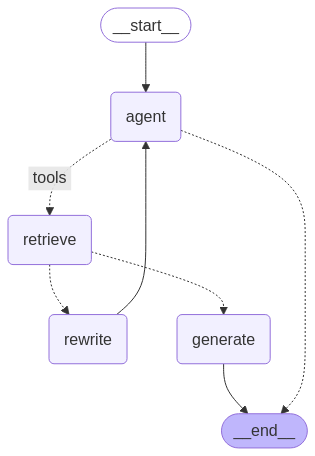

In [7]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Ask question from your gmail inbox here.

In [8]:
import pprint

inputs = {
    "messages": [
        ("user", "list all the job/internship offers that I have received for ai/ml"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'name': 'agentic_retriever', 'arguments': '{"query": "list all the job/internship offers that I have received for ai/ml"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-2ad9c02e-980b-4b04-86eb-67ced5f8cd2b-0', tool_calls=[{'name': 'agentic_retriever', 'args': {'query': 'list all the job/internship offers that I have received for ai/ml'}, 'id': '794fdb43-fddf-42af-9daa-2cd07fb35c27', 'type': 'tool_call'}], usage_metadata={'input_tokens': 164, 'output_tokens': 22, 'total_tokens': 186, 'input_token_details': {'cache_read': 0}})]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='From: LinkedIn <jobs-listings@linkedin.com>\nTo: Soham Agarwal <sohamagarwal5